In [1]:
#export
import pandas as pd
import numpy as np
import pdvega
import json

In [2]:
DATA_LOC = '../data/'

## Standard for næringsgruppering (SN)
kilde: https://www.ssb.no/klass/klassifikasjoner/6

In [3]:
nace_2007 = pd.read_csv(DATA_LOC + '30.csv', sep=';', encoding='iso-8859-1') 
nace_2007.head(1)

,code,parentCode,level,name,shortName,notes,validFrom,validTo
0,01,A,2,"Jordbruk og tjenester tilknyttet jordbruk, jak...","Jordbruk, tilhør. tjenester, jakt",Inkluderer: Denne næringen omfatter to basisak...,NaN,NaN


## NACE (næringsgruppe) koder pr foretak

In [4]:
nace = pd.read_csv(DATA_LOC + 'EnhetNacekode.tab', sep='\t', encoding='utf-8', dtype={'nacekode': object}) 
nace_pivot = pd.pivot_table(nace.sort_values(by=['orgnr', 'rekkefolge']),
                            index='orgnr', columns='rekkefolge',
                            values='nacekode', aggfunc='first').reset_index()
nace_pivot.columns=['orgnr', 'nace_1', 'nace_2', 'nace_3','nace_4']
nace_pivot.head(1)

,orgnr,nace_1,nace_2,nace_3,nace_4
0,810033622,68.209,NaN,NaN,NaN


In [5]:
len(nace_pivot)

1070788

In [6]:
enhet = pd.read_csv(DATA_LOC + 'EnhetNavnOrgform.tab', sep='\t', encoding='iso-8859-1') 
enhet.head()

,orgnr,orgform,navn
0,810033622,AS,WILTHIL & CO AS
1,810034882,AS,SANDNES ELEKTRISKE FORRETNING AS
2,810059672,AS,AASEN & FARSTAD AS
3,810093382,AS,BRIS EIENDOM AS
4,810094532,AS,AGDERPOSTEN MEDIER AS


In [7]:
len(enhet)

1124902

## Beskrivelser for NACE kodene

In [8]:
nace_beskrivelse = pd.read_csv(DATA_LOC + 'nace_beskrivelse.tab', sep='\t', encoding='utf-8', dtype={'nacekode': object}) 
nace_beskrivelse.drop(['beskrivelse2'], axis=1, inplace=True)
nace_beskrivelse.columns = ['nace', 'tekst']

In [9]:
nace_beskrivelse.head()

,nace,tekst
0,00.000,Uoppgitt
1,01.110,"Dyrking av korn (unntatt ris), belgvekster og ..."
2,01.120,Dyrking av ris
3,01.130,"Dyrking av grønnsaker, meloner, rot- og knollv..."
4,01.140,Dyrking av sukkerrør


In [10]:
nace_beskrivelse.to_json(DATA_LOC + 'nace_beskrivelse.json', orient="records")

## Formålet med virksomheten beskrevet i tekst

In [11]:
formål = pd.read_csv(DATA_LOC + 'EnhetOrgformVirksomhetArtBransje.tab', sep='\t', encoding='iso-8859-1') 
formål.columns = ['orgnr', 'orgform', 'linje_nr', 'linje_tekst']

In [12]:
len(formål)

1901937

In [13]:
formål.head(5)

,orgnr,orgform,linje_nr,linje_tekst
0,810033622,AS,1,"Handel, engros og detalj og agenturer, herunder"
1,810033622,AS,2,import av varer.
2,810034882,AS,10,"Handel og innstallasjonsvirksomhet, eller anne..."
3,810034882,AS,20,"med dette, samt delta I annen virksomhet."
4,810059672,AS,10,Utleie av forretningseiendommer.


In [14]:
# eksempel: før sammenslåing
list(formål[formål['orgnr'] == 810034882]['linje_tekst'])

['Handel og innstallasjonsvirksomhet, eller annen virksomhet forbundet',
 'med dette, samt delta I annen virksomhet.']

In [15]:
# eksempel: etter sammenslåing
formål_t = formål[['orgnr','linje_tekst']].groupby('orgnr')['linje_tekst'].apply(lambda x: ' '.join(x)).reset_index()

In [16]:
list(formål_t[formål_t['orgnr'] == 810034882]['linje_tekst'])

['Handel og innstallasjonsvirksomhet, eller annen virksomhet forbundet med dette, samt delta I annen virksomhet.']

In [17]:
len(formål_t)

1102419

In [18]:
formål_t.head()

,orgnr,linje_tekst
0,810033622,"Handel, engros og detalj og agenturer, herunde..."
1,810034882,"Handel og innstallasjonsvirksomhet, eller anne..."
2,810059672,Utleie av forretningseiendommer.
3,810093382,"Eie og drift av fast eiendom, investering i ak..."
4,810094532,Utgi avisen Agderposten og drive annen virksom...


In [116]:
df = pd.merge(formål_t, nace_pivot, on='orgnr', how='inner') 

In [117]:
# TODO: drop konkurser, ukjent osv

In [118]:
len(df)

1049701

In [137]:
df['lengde_linje_tekst'] = df['linje_tekst'].apply(lambda x: len(x))
df = df[df['lengde_linje_tekst']>4]

In [138]:
len(df)

1005367

## Datasett for maskinlæring

In [22]:
import spacy
import re

# laster spåkmodell fra norsk_spacy (nb! denne er ikke publisert offentlig enda og vil ikke fungere utenfor NAV)
nlp = spacy.load('nb_ud_ner')

def tokenize(x):
    tokens = nlp.tokenizer(x)
    return [t.text.lower() for t in tokens if not t.is_punct]

In [23]:
# test
tokenize('Handel og innstallasjonsvirksomhet, eller annen virksomhet forbundet med dette, samt delta I annen virksomhet.')

['handel',
 'og',
 'innstallasjonsvirksomhet',
 'eller',
 'annen',
 'virksomhet',
 'forbundet',
 'med',
 'dette',
 'samt',
 'delta',
 'i',
 'annen',
 'virksomhet']

In [24]:
#export
def get_dataset(row):
    s = row['linje_tekst']
    tokens = tokenize(s)
    tokens.append(f"__label__{row['nace_1']}")
    linje = ' '.join(tokens)
    return linje

In [25]:
dataset = df.apply(get_dataset, axis=1)

In [26]:
dataset.head(5)

0    handel engros og detalj og agenturer herunder ...
1    handel og innstallasjonsvirksomhet eller annen...
2      utleie av forretningseiendommer __label__68.209
3    eie og drift av fast eiendom investering i aks...
4    utgi avisen agderposten og drive annen virksom...
dtype: object

In [27]:
len(dataset)

1049701

In [28]:
dataset.iloc[0]

'handel engros og detalj og agenturer herunder import av varer __label__68.209'

In [29]:
# oppdeling av datasettet i 90% trening, 10% validering
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.1)
#train, test = np.split(dataset.sample(frac=1), [int(.9*len(dataset))])

In [30]:
train.to_csv(DATA_LOC + 'næringskoder_train.txt',
                                       header = None,
                                      index = None,
                                      sep = ' ', encoding='utf-8')

In [31]:
test.to_csv(DATA_LOC + 'næringskoder_test.txt',
                                       header = None,
                                      index = None,
                                      sep = ' ', encoding='utf-8')

## Trene modell 

In [32]:
#export
import fastText
from fastText import train_supervised, tokenize, load_model, unicode_literals

In [33]:
# list metoder
# dir(fastText)

In [34]:
#export
model = train_supervised(
    input = DATA_LOC + 'næringskoder_train.txt',
    wordNgrams = 3,
    label = '__label__',
    verbose = 2,
    minCount = 1,
    neg = 10
)

In [35]:
# list metoder
# dir(model)

In [36]:
model.save_model(DATA_LOC + 'nace_model.bin')

In [249]:
model.quantize(DATA_LOC + 'nace_model_quantized.bin')

In [37]:
#export
def print_results(N,p,r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1,p))
    print("R@{}\t{:.3f}".format(1,r))

In [38]:
print_results(*model.test(DATA_LOC + 'næringskoder_validate.txt'))

N	55683
P@1	0.659
R@1	0.659


In [39]:
#export
def predict_nace(model, tekst, k):
    res = {}
    res['nace'] = []
    pred = model.predict(tekst, k=k)
    for index, item in enumerate(pred[0]):
        res['nace'].append({'nace': item.replace('__label__', ''), 'prob': pred[1][index] })
    return res

In [40]:
tekst = test.iloc[400][:-16]
print(tekst)

rørleggerforretning


In [41]:
predict_nace(model, tekst, 5)

{'nace': [{'nace': '43.221"', 'prob': 0.9992423057556152},
  {'nace': '43.223"', 'prob': 0.00037410392542369664},
  {'nace': '43.222"', 'prob': 0.00028277465025894344},
  {'nace': '43.290"', 'prob': 3.921931056538597e-05},
  {'nace': '43.911"', 'prob': 3.6551431549014524e-05}]}

In [42]:
test.values

array(['konkursbo __label__68.100',
       'drive med bilberging og utleie av driftsmidler __label__52.219',
       'investeringsvirksomhet og konsulentvirksomhet salg av konsulenttjenester innenfor varehandel __label__82.990',
       ..., 'salg av luftrensere av typen fresh air __label__47.990',
       'mekaniske reparasjoner snørydding med egen traktor __label__33.120',
       'hafs fiskarlag er eit lokallag under norges fiskarlag __label__94.991'],
      dtype=object)

In [43]:
test.values[:10]

array(['konkursbo __label__68.100',
       'drive med bilberging og utleie av driftsmidler __label__52.219',
       'investeringsvirksomhet og konsulentvirksomhet salg av konsulenttjenester innenfor varehandel __label__82.990',
       'huseierforening for 13 rekkehus boenheter __label__94.991',
       'utvikling og salg av mindre tomteområde i gjesdal kommune __label__41.109',
       'avvirkning dyrking av jordbruksvekster i tillegg til alminnelig næring kjøp av tømmer for tilvirking til vedsalg __label__02.200',
       'klubbens formål er å ta vare på det sosiale samværet blant klubbens medlemmer __label__94.991',
       'idrettslag __label__93.120',
       'webdesign spilldesign og annen interaktive applikasjoner __label__62.020',
       'maskinentreprenør __label__42.120'], dtype=object)

In [44]:
pred_list=[]
for index, row in enumerate(test.values):
    nace = row[-6:]
    line = row[:-16]
    length = len(line)
    if (length > 1):
        pred = predict_nace(model, line,3)
        pred_1 = pred['nace'][0]['nace'][-7:-1]
        pred_2 = pred['nace'][1]['nace'][-7:-1]
        pred_3 = pred['nace'][2]['nace'][-7:-1]

        korrekt = 'Nei'
        if pred_1 == nace:
            korrekt = 'Ja'

        if nace in [pred_2,pred_3]:
            korrekt = 'Delvis'

        pred_list.append([index, nace, korrekt, pred_1, pred_2, pred_3,line])
    else:
        print(row)
        
pred = pd.DataFrame(pred_list)
pred.columns=['index','nace','korrekt','pred_1','pred_2','pred_3','tekst']

c __label__36.000


In [139]:
# 10% split
len(pred)

104970

In [46]:
pred.head()

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst
0,0,68.100,Nei,82.990,47.990,96.090,konkursbo
1,1,52.219,Nei,77.110,43.120,77.390,drive med bilberging og utleie av driftsmidler
2,2,82.990,Nei,70.220,68.209,64.308,investeringsvirksomhet og konsulentvirksomhet ...
3,3,94.991,Nei,68.209,68.320,41.109,huseierforening for 13 rekkehus boenheter
4,4,41.109,Ja,41.109,68.209,68.100,utvikling og salg av mindre tomteområde i gjes...


In [143]:
resultat = pred[['index','nace','korrekt']].groupby(['nace','korrekt']).count().reset_index().rename(columns={'index':'count'})

In [144]:
resultat.head()

,nace,korrekt,count
0,00.000,Delvis,428
1,00.000,Ja,414
2,00.000,Nei,637
3,01.110,Delvis,213
4,01.110,Ja,795


In [156]:
pv = pd.pivot_table(resultat, index='nace', columns='korrekt').reset_index()

In [167]:
pv = pd.pivot_table(resultat, index='nace', columns='korrekt').reset_index()
pv.fillna(0, inplace = True)
pv.columns = ['nace', 'delvis_korrekt','korrekt','feil']
pv['antall'] = pv['feil'] + pv['korrekt'] + pv['delvis_korrekt']
pv['andel_korrekt'] = 100 * pv['korrekt'] / pv['antall']
pv['andel_feil'] = 100 * pv['feil'] / pv['antall']
pv['andel_delvis_korrekt'] = 100 * (pv['korrekt'] + pv['delvis_korrekt']) / pv['antall']
pv.sort_values(by='andel_feil', ascending = False, inplace=True) 

In [168]:
count = resultat[['nace','count']].groupby('nace').sum().reset_index()
pv = pd.merge(pv, count, how='left', on='nace')

## Andel korrekte fastsettelser

In [191]:
pv_t = pd.merge(pv,nace_beskrivelse, how='left', on='nace')
pv_t.rename(columns={'tekst':'nace_beskrivelse'}, inplace=True)

### Høy treffsikkerhet

In [196]:
pv_t.sort_values(by='andel_feil', ascending = True, inplace=True)
pv_t.head(20)

,nace,delvis_korrekt,korrekt,feil,antall,andel_korrekt,andel_feil,andel_delvis_korrekt,count,nace_hoved,nace_beskrivelse
741,68.201,6.0,877.0,19.0,902.0,97.228381,2.106430,97.893570,902,68,Borettslag
740,94.920,18.0,265.0,9.0,292.0,90.753425,3.082192,96.917808,292,94,Partipolitiske organisasjoner
739,86.211,48.0,1274.0,67.0,1389.0,91.720662,4.823614,95.176386,1389,86,Allmenn legetjeneste
738,49.320,27.0,778.0,50.0,855.0,90.994152,5.847953,94.152047,855,49,Drosjebiltransport
737,96.020,73.0,1395.0,93.0,1561.0,89.365791,5.957719,94.042281,1561,96,Frisering og annen skjønnhetspleie
736,86.902,46.0,622.0,46.0,714.0,87.114846,6.442577,93.557423,714,86,Fysioterapitjeneste
735,86.905,34.0,285.0,25.0,344.0,82.848837,7.267442,92.732558,344,86,Klinisk psykologtjeneste
734,93.120,202.0,895.0,88.0,1185.0,75.527426,7.426160,92.573840,1185,93,Idrettslag og -klubber
733,88.911,17.0,325.0,29.0,371.0,87.601078,7.816712,92.183288,371,88,Barnehager
732,86.230,24.0,526.0,48.0,598.0,87.959866,8.026756,91.973244,598,86,Tannhelsetjenester


### Lav treffsikkerhet

In [198]:
pv_t.tail(20)

,nace,delvis_korrekt,korrekt,feil,antall,andel_korrekt,andel_feil,andel_delvis_korrekt,count,nace_hoved,nace_beskrivelse
17,46.432,0.0,0.0,17.0,17.0,0.0,100.0,0.0,17,46,Engroshandel med radio og fjernsyn
15,46.434,0.0,0.0,6.0,6.0,0.0,100.0,0.0,6,46,Engroshandel med fotoutstyr
14,46.435,0.0,0.0,9.0,9.0,0.0,100.0,0.0,9,46,Engroshandel med optiske artikler
13,46.442,0.0,0.0,16.0,16.0,0.0,100.0,0.0,16,46,Engroshandel med rengjøringsmidler
12,46.472,0.0,0.0,7.0,7.0,0.0,100.0,0.0,7,46,Engroshandel med gulvtepper
11,46.481,0.0,0.0,6.0,6.0,0.0,100.0,0.0,6,46,Engroshandel med klokker og ur
10,46.482,0.0,0.0,16.0,16.0,0.0,100.0,0.0,16,46,Engroshandel med gull- og sølvvarer
66,30.990,0.0,0.0,3.0,3.0,0.0,100.0,0.0,3,30,Produksjon av andre transportmidler ikke nevnt...
9,46.491,0.0,0.0,8.0,8.0,0.0,100.0,0.0,8,46,"Engroshandel med bøker, aviser og blader"
8,46.492,0.0,0.0,6.0,6.0,0.0,100.0,0.0,6,46,Engroshandel med reiseeffekter og lærvarer


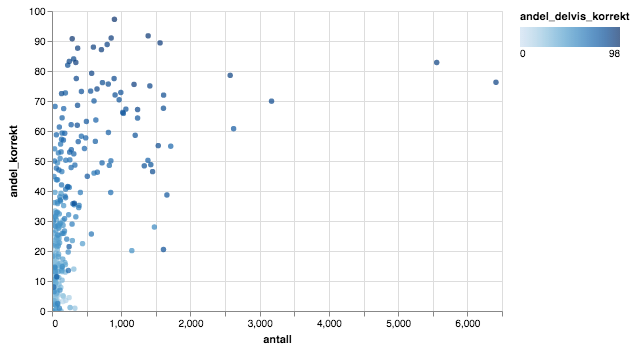

In [184]:
plot = pv_t.vgplot.scatter(x='antall', y='andel_korrekt', c='andel_delvis_korrekt')
plot.display()

In [201]:
#plot.spec

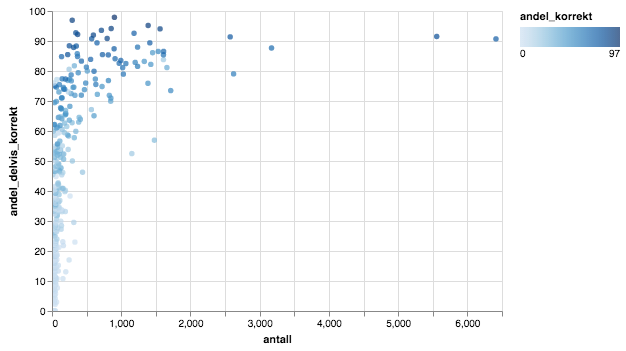

In [185]:
pv_t.vgplot.scatter(x='antall', y='andel_delvis_korrekt', c='andel_korrekt')

In [222]:
pv_t['sum_antall'] = pv_t['antall'].cumsum()

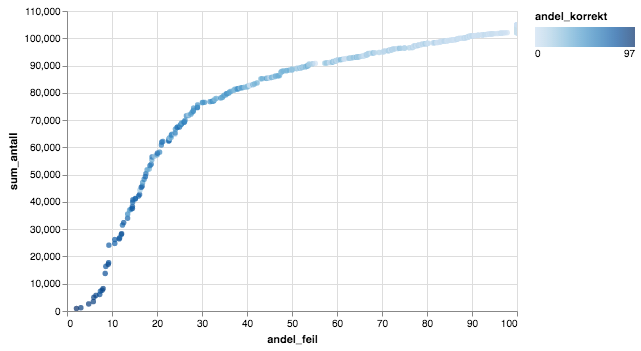

In [226]:
pv_t.vgplot.scatter(x='andel_feil', y='sum_antall', c='andel_korrekt')

In [202]:
pv_t['nace_hoved'] = pv_t['nace'].apply(lambda x: x[0:2])

In [203]:
pv_t.head(1)

,nace,delvis_korrekt,korrekt,feil,antall,andel_korrekt,andel_feil,andel_delvis_korrekt,count,nace_hoved,nace_beskrivelse
741,68.201,6.0,877.0,19.0,902.0,97.228381,2.10643,97.89357,902,68,Borettslag


In [215]:
pvh = pv_t[['nace_hoved','antall','korrekt','delvis_korrekt','feil']].groupby(['nace_hoved']).sum().reset_index()
pvh = pvh[pvh['antall']>0]
pvh['andel_feil'] = 100*pvh['feil']/pvh['antall']

In [216]:
pvh = pd.merge(pvh, nace_2007[['code','name']], how="left", left_on='nace_hoved', right_on='code')
pvh.rename(columns={'name':'nace_hoved_beskrivelse'}, inplace=True)

In [217]:
pvh.sort_values(by='andel_feil', ascending = True, inplace=True) 

In [218]:
pvh.head(20)

,nace_hoved,antall,korrekt,delvis_korrekt,feil,andel_feil,code,nace_hoved_beskrivelse
83,94,7320.0,5826.0,772.0,722.0,9.863388,94,Aktiviteter i medlemsorganisasjoner
86,97,250.0,208.0,13.0,29.0,11.600000,97,Lønnet arbeid i private husholdninger
60,68,9998.0,6524.0,2249.0,1225.0,12.252450,68,Omsetning og drift av fast eiendom
76,86,5387.0,4083.0,616.0,688.0,12.771487,86,Helsetjenester
38,41,4633.0,2893.0,1138.0,602.0,12.993741,41,Oppføring av bygninger
44,49,2622.0,1950.0,306.0,366.0,13.958810,49,Landtransport og rørtransport
67,75,227.0,186.0,8.0,33.0,14.537445,75,Veterinærtjenester
34,36,138.0,100.0,17.0,21.0,15.217391,36,"Uttak fra kilde, rensing og distribusjon av vann"
2,02,1708.0,1116.0,316.0,276.0,16.159251,02,Skogbruk og tjenester tilknyttet skogbruk
85,96,2550.0,1819.0,312.0,419.0,16.431373,96,Annen personlig tjenesteyting


In [219]:
pvh.tail(20)

,nace_hoved,antall,korrekt,delvis_korrekt,feil,andel_feil,code,nace_hoved_beskrivelse
12,13,137.0,5.0,3.0,129.0,94.160584,13,Produksjon av tekstiler
54,61,123.0,1.0,6.0,116.0,94.308943,61,Telekommunikasjon
5,06,18.0,0.0,1.0,17.0,94.444444,06,Utvinning av råolje og naturgass
58,65,18.0,1.0,0.0,17.0,94.444444,65,"Forsikringsvirksomhet og pensjonskasser, unnta..."
77,87,47.0,0.0,0.0,47.0,100.000000,87,Pleie- og omsorgstjenester i institusjon
6,07,2.0,0.0,0.0,2.0,100.000000,07,Bryting av metallholdig malm
4,05,2.0,0.0,0.0,2.0,100.000000,05,Bryting av steinkull og brunkull
19,20,53.0,0.0,0.0,53.0,100.000000,20,Produksjon av kjemikalier og kjemiske produkter
14,15,17.0,0.0,0.0,17.0,100.000000,15,Produksjon av lær og lærvarer
16,17,9.0,0.0,0.0,9.0,100.000000,17,Produksjon av papir og papirvarer


In [227]:
pvh['sum_antall'] = pvh['antall'].cumsum()

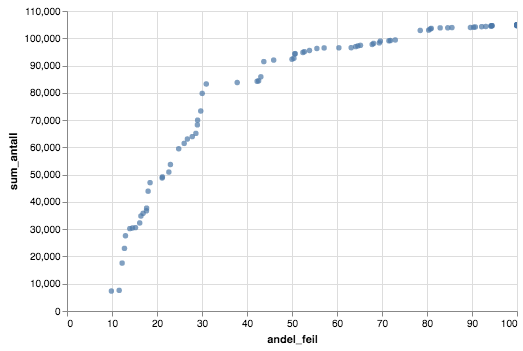

In [228]:
pvh.vgplot.scatter(x='andel_feil', y='sum_antall')

In [239]:
pred['nace_hoved'] = pred['nace'].apply(lambda x: x[0:2])
data = pd.merge(pred,nace_beskrivelse.rename(columns={'tekst':'nace_beskrivelse'}), how='left', on='nace')
data.head(10)

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_hoved,nace_beskrivelse
0,0,68.100,Nei,82.990,47.990,96.090,konkursbo,68,Kjøp og salg av egen fast eiendom
1,1,52.219,Nei,77.110,43.120,77.390,drive med bilberging og utleie av driftsmidler,52,Tjenester tilknyttet landtransport ellers
2,2,82.990,Nei,70.220,68.209,64.308,investeringsvirksomhet og konsulentvirksomhet ...,82,Annen forretningsmessig tjenesteyting ikke nev...
3,3,94.991,Nei,68.209,68.320,41.109,huseierforening for 13 rekkehus boenheter,94,Aktiviteter i andre interesseorganisasjoner ik...
4,4,41.109,Ja,41.109,68.209,68.100,utvikling og salg av mindre tomteområde i gjes...,41,Utvikling og salg av egen fast eiendom ellers
5,5,02.200,Ja,02.200,01.110,01.190,avvirkning dyrking av jordbruksvekster i tille...,02,Avvirkning
6,6,94.991,Ja,94.991,93.120,88.995,klubbens formål er å ta vare på det sosiale sa...,94,Aktiviteter i andre interesseorganisasjoner ik...
7,7,93.120,Ja,93.120,94.991,93.190,idrettslag,93,Idrettslag og -klubber
8,8,62.020,Delvis,62.010,62.020,63.120,webdesign spilldesign og annen interaktive app...,62,Konsulentvirksomhet tilknyttet informasjonstek...
9,9,42.120,Nei,43.120,42.210,43.990,maskinentreprenør,42,Bygging av jernbaner og undergrunnsbaner


In [240]:
data = pd.merge(data,nace_beskrivelse.rename(columns={'tekst':'nace_beskrivelse'}), how='left', left_on='pred_1', right_on='nace', suffixes=['','_pred_1'])
data = pd.merge(data,nace_beskrivelse.rename(columns={'tekst':'nace_beskrivelse'}), how='left', left_on='pred_2', right_on='nace', suffixes=['','_pred_2'])
data = pd.merge(data,nace_beskrivelse.rename(columns={'tekst':'nace_beskrivelse'}), how='left', left_on='pred_3', right_on='nace', suffixes=['','_pred_3'])

In [241]:
from IPython.display import display
display(data)

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_hoved,nace_beskrivelse,nace_pred_1,nace_beskrivelse_pred_1,nace_pred_2,nace_beskrivelse_pred_2,nace_pred_3,nace_beskrivelse_pred_3
0,0,68.100,Nei,82.990,47.990,96.090,konkursbo,68,Kjøp og salg av egen fast eiendom,82.990,Annen forretningsmessig tjenesteyting ikke nev...,47.990,Detaljhandel utenom utsalgssted ellers,96.090,Personlig tjenesteyting ikke nevnt annet sted
1,1,52.219,Nei,77.110,43.120,77.390,drive med bilberging og utleie av driftsmidler,52,Tjenester tilknyttet landtransport ellers,77.110,Utleie og leasing av biler og andre lette moto...,43.120,Grunnarbeid,77.390,Utleie og leasing av andre maskiner og annet u...
2,2,82.990,Nei,70.220,68.209,64.308,investeringsvirksomhet og konsulentvirksomhet ...,82,Annen forretningsmessig tjenesteyting ikke nev...,70.220,Bedriftsrådgivning og annen administrativ rådg...,68.209,Utleie av egen eller leid fast eiendom ellers,64.308,Investeringsselskaper og lignende lukket for a...
3,3,94.991,Nei,68.209,68.320,41.109,huseierforening for 13 rekkehus boenheter,94,Aktiviteter i andre interesseorganisasjoner ik...,68.209,Utleie av egen eller leid fast eiendom ellers,68.320,Eiendomsforvaltning,41.109,Utvikling og salg av egen fast eiendom ellers
4,4,41.109,Ja,41.109,68.209,68.100,utvikling og salg av mindre tomteområde i gjes...,41,Utvikling og salg av egen fast eiendom ellers,41.109,Utvikling og salg av egen fast eiendom ellers,68.209,Utleie av egen eller leid fast eiendom ellers,68.100,Kjøp og salg av egen fast eiendom
5,5,02.200,Ja,02.200,01.110,01.190,avvirkning dyrking av jordbruksvekster i tille...,02,Avvirkning,02.200,Avvirkning,01.110,"Dyrking av korn (unntatt ris), belgvekster og ...",01.190,Dyrking av ettårige vekster ellers
6,6,94.991,Ja,94.991,93.120,88.995,klubbens formål er å ta vare på det sosiale sa...,94,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,93.120,Idrettslag og -klubber,88.995,Sosiale velferdsorganisasjoner
7,7,93.120,Ja,93.120,94.991,93.190,idrettslag,93,Idrettslag og -klubber,93.120,Idrettslag og -klubber,94.991,Aktiviteter i andre interesseorganisasjoner ik...,93.190,Andre sportsaktiviteter
8,8,62.020,Delvis,62.010,62.020,63.120,webdesign spilldesign og annen interaktive app...,62,Konsulentvirksomhet tilknyttet informasjonstek...,62.010,Programmeringstjenester,62.020,Konsulentvirksomhet tilknyttet informasjonstek...,63.120,Drift av web-portaler
9,9,42.120,Nei,43.120,42.210,43.990,maskinentreprenør,42,Bygging av jernbaner og undergrunnsbaner,43.120,Grunnarbeid,42.210,Bygging av vann- og kloakkanlegg,43.990,Annen spesialisert bygge- og anleggsvirksomhet


In [242]:
print(f"Antall: {len(data[data['nace']=='46.150'])}")
data[data['nace_hoved']=='13']

Antall: 47


,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_hoved,nace_beskrivelse,nace_pred_1,nace_beskrivelse_pred_1,nace_pred_2,nace_beskrivelse_pred_2,nace_pred_3,nace_beskrivelse_pred_3
658,658,13.921,Nei,14.130,95.290,14.190,sying av nye klær gardiner og annet reparasjon...,13,Produksjon av utstyrsvarer,14.130,Produksjon av annet yttertøy,95.290,Reparasjon av andre husholdningsvarer og varer...,14.190,Produksjon av klær og tilbehør ellers
686,686,13.990,Nei,47.510,47.710,14.130,bearbeider tekstiler med firmalogoer eventuelt...,13,Produksjon av tekstiler ikke nevnt annet sted,47.510,Butikkhandel med tekstiler og utstyrsvarer,47.710,Butikkhandel med klær,14.130,Produksjon av annet yttertøy
2011,2011,13.929,Nei,43.320,43.330,43.990,produksjon salg og montering av innvendig og u...,13,"Produksjon av andre tekstilvarer, unntatt klær",43.320,Snekkerarbeid,43.330,Gulvlegging og tapetsering,43.990,Annen spesialisert bygge- og anleggsvirksomhet
2710,2710,13.940,Nei,03.111,03.211,50.109,industrielt agn for linefiske fiskeri,13,Produksjon av tauverk og nett,03.111,Hav- og kystfiske,03.211,Produksjon av matfisk og skalldyr i hav- og ky...,50.109,Kysttrafikk ellers med passasjerer
3337,3337,13.100,Nei,01.451,01.420,01.410,jordbruk dyrking av jordbruksvektster husdyrho...,13,Bearbeiding og spinning av tekstilfibrer,01.451,Sauehold,01.420,Oppdrett av annet storfe,01.410,Melkeproduksjon på storfe
3683,3683,13.300,Nei,90.034,74.300,73.110,maskinbrodering av tekst og logo på tekstiler,13,Etterbehandling av tekstiler,90.034,Selvstendig kunstnerisk virksomhet innen litte...,74.300,Oversettelses- og tolkevirksomhet,73.110,Reklamebyråer
3746,3746,13.940,Nei,71.129,28.290,33.120,produksjon og reparasjon av fiskenot og trål e...,13,Produksjon av tauverk og nett,71.129,Annen teknisk konsulentvirksomhet,28.290,Produksjon av maskiner og utstyr til generell ...,33.120,Reparasjon av maskiner
4775,4775,13.930,Nei,90.031,96.090,90.034,produksjon og salg av husflidsartikler kursvir...,13,"Produksjon av gulvtepper, -matter og -ryer",90.031,Selvstendig kunstnerisk virksomhet innen visue...,96.090,Personlig tjenesteyting ikke nevnt annet sted,90.034,Selvstendig kunstnerisk virksomhet innen litte...
5277,5277,13.200,Nei,68.209,56.101,47.789,vevstue med egne produkter og kurs pluss utlei...,13,Veving av tekstiler,68.209,Utleie av egen eller leid fast eiendom ellers,56.101,Drift av restauranter og kafeer,47.789,Butikkhandel ikke nevnt annet sted
5456,5456,13.929,Nei,32.990,47.990,01.490,produksjon og salg av ammeputer og andre sømpr...,13,"Produksjon av andre tekstilvarer, unntatt klær",32.990,Annen industriproduksjon ikke nevnt annet sted,47.990,Detaljhandel utenom utsalgssted ellers,01.490,Husdyrhold ellers


In [244]:
data[data['nace_hoved']=='61']

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_hoved,nace_beskrivelse,nace_pred_1,nace_beskrivelse_pred_1,nace_pred_2,nace_beskrivelse_pred_2,nace_pred_3,nace_beskrivelse_pred_3
1232,1232,61.200,Nei,78.200,71.129,78.100,utleie av ingeniører og annet personell til ar...,61,Trådløs telekommunikasjon,78.200,Utleie av arbeidskraft,71.129,Annen teknisk konsulentvirksomhet,78.100,Rekruttering og formidling av arbeidskraft
2085,2085,61.300,Nei,61.100,61.900,61.200,telekommunikasjon,61,Satellittbasert telekommunikasjon,61.100,Kabelbasert telekommunikasjon,61.900,Telekommunikasjon ellers,61.200,Trådløs telekommunikasjon
2479,2479,61.200,Nei,63.110,62.090,62.020,teletjenester data og internett,61,Trådløs telekommunikasjon,63.110,"Databehandling, datalagring og tilknyttede tje...",62.090,Andre tjenester tilknyttet informasjonsteknologi,62.020,Konsulentvirksomhet tilknyttet informasjonstek...
2584,2584,61.100,Delvis,82.202,82.110,61.100,ip telefoni,61,Kabelbasert telekommunikasjon,82.202,Telefonsalg,82.110,Kombinerte kontortjenester,61.100,Kabelbasert telekommunikasjon
3134,3134,61.900,Nei,01.620,82.110,68.320,ivareta andelseiernes interesser i tilknyttnin...,61,Telekommunikasjon ellers,01.620,Tjenester tilknyttet husdyrhold,82.110,Kombinerte kontortjenester,68.320,Eiendomsforvaltning
3400,3400,61.100,Nei,50.109,03.111,52.221,drive internettkafe,61,Kabelbasert telekommunikasjon,50.109,Kysttrafikk ellers med passasjerer,03.111,Hav- og kystfiske,52.221,Drift av havne- og kaianlegg
5637,5637,61.200,Nei,62.010,63.120,47.919,internett cafe telefonkort salg av mobil og da...,61,Trådløs telekommunikasjon,62.010,Programmeringstjenester,63.120,Drift av web-portaler,47.919,Postordre-/Internetthandel med annet spesialis...
5762,5762,61.100,Nei,71.129,94.991,43.210,reparasjon utbygging utbedring utvidelse og op...,61,Kabelbasert telekommunikasjon,71.129,Annen teknisk konsulentvirksomhet,94.991,Aktiviteter i andre interesseorganisasjoner ik...,43.210,Elektrisk installasjonsarbeid
6630,6630,61.900,Delvis,71.129,61.900,70.220,konsulenttjenester innen telekommunikasjon,61,Telekommunikasjon ellers,71.129,Annen teknisk konsulentvirksomhet,61.900,Telekommunikasjon ellers,70.220,Bedriftsrådgivning og annen administrativ rådg...
7044,7044,61.100,Nei,68.209,62.020,70.220,salg av varer leveranse og drift av tjenester ...,61,Kabelbasert telekommunikasjon,68.209,Utleie av egen eller leid fast eiendom ellers,62.020,Konsulentvirksomhet tilknyttet informasjonstek...,70.220,Bedriftsrådgivning og annen administrativ rådg...


In [245]:
data[data['nace_hoved']=='06']

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_hoved,nace_beskrivelse,nace_pred_1,nace_beskrivelse_pred_1,nace_pred_2,nace_beskrivelse_pred_2,nace_pred_3,nace_beskrivelse_pred_3
7900,7900,06.100,Nei,35.111,71.129,09.109,virksomhet i forbindelse med utforskning utbyg...,06,Utvinning av råolje,35.111,Produksjon av elektrisitet fra vannkraft,71.129,Annen teknisk konsulentvirksomhet,09.109,Andre tjenester tilknyttet utvinning av råolje...
11769,11769,06.100,Nei,71.129,71.122,68.209,undersøkelse etter og utnyttelse av petroleum ...,06,Utvinning av råolje,71.129,Annen teknisk konsulentvirksomhet,71.122,Geologiske undersøkelser,68.209,Utleie av egen eller leid fast eiendom ellers
15302,15302,06.100,Nei,71.129,09.109,71.122,oljeboring,06,Utvinning av råolje,71.129,Annen teknisk konsulentvirksomhet,09.109,Andre tjenester tilknyttet utvinning av råolje...,71.122,Geologiske undersøkelser
19826,19826,06.100,Nei,68.209,50.201,82.990,å drive virksomhet i forbindelse med petroleum...,06,Utvinning av råolje,68.209,Utleie av egen eller leid fast eiendom ellers,50.201,Utenriks sjøfart med gods,82.990,Annen forretningsmessig tjenesteyting ikke nev...
22584,22585,06.200,Nei,71.129,71.122,09.109,leting etter og produksjon hydrokarboner,06,Utvinning av naturgass,71.129,Annen teknisk konsulentvirksomhet,71.122,Geologiske undersøkelser,09.109,Andre tjenester tilknyttet utvinning av råolje...
28734,28735,06.100,Delvis,09.109,71.129,06.100,virksomhet i forbindelse med utforskning utbyg...,06,Utvinning av råolje,09.109,Andre tjenester tilknyttet utvinning av råolje...,71.129,Annen teknisk konsulentvirksomhet,06.100,Utvinning av råolje
32529,32530,06.100,Nei,68.209,70.220,50.201,petroleumsleting og -utvinning og hva som derm...,06,Utvinning av råolje,68.209,Utleie av egen eller leid fast eiendom ellers,70.220,Bedriftsrådgivning og annen administrativ rådg...,50.201,Utenriks sjøfart med gods
36514,36515,06.100,Nei,09.109,71.129,71.122,petroleumsvirksomhet på norsk kontinentalsokkel,06,Utvinning av råolje,09.109,Andre tjenester tilknyttet utvinning av råolje...,71.129,Annen teknisk konsulentvirksomhet,71.122,Geologiske undersøkelser
38445,38446,06.100,Nei,09.109,35.111,71.129,drive virksomhet i forbindelse med utforskning...,06,Utvinning av råolje,09.109,Andre tjenester tilknyttet utvinning av råolje...,35.111,Produksjon av elektrisitet fra vannkraft,71.129,Annen teknisk konsulentvirksomhet
50622,50623,06.100,Nei,50.201,35.111,68.209,selskapet har til formål å drive virksomhet i ...,06,Utvinning av råolje,50.201,Utenriks sjøfart med gods,35.111,Produksjon av elektrisitet fra vannkraft,68.209,Utleie av egen eller leid fast eiendom ellers


In [246]:
print(f"Antall: {len(data[data['nace']=='94.991'])}")
data[data['nace']=='94.991'].head(20)

Antall: 5557


,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_hoved,nace_beskrivelse,nace_pred_1,nace_beskrivelse_pred_1,nace_pred_2,nace_beskrivelse_pred_2,nace_pred_3,nace_beskrivelse_pred_3
3,3,94.991,Nei,68.209,68.320,41.109,huseierforening for 13 rekkehus boenheter,94,Aktiviteter i andre interesseorganisasjoner ik...,68.209,Utleie av egen eller leid fast eiendom ellers,68.320,Eiendomsforvaltning,41.109,Utvikling og salg av egen fast eiendom ellers
6,6,94.991,Ja,94.991,93.120,88.995,klubbens formål er å ta vare på det sosiale sa...,94,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,93.120,Idrettslag og -klubber,88.995,Sosiale velferdsorganisasjoner
22,22,94.991,Nei,68.209,68.320,82.990,arbeide for realsering av fergeforbindelse mel...,94,Aktiviteter i andre interesseorganisasjoner ik...,68.209,Utleie av egen eller leid fast eiendom ellers,68.320,Eiendomsforvaltning,82.990,Annen forretningsmessig tjenesteyting ikke nev...
30,30,94.991,Ja,94.991,68.320,93.120,arbeide for gode adkomstmuligheter til området...,94,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,68.320,Eiendomsforvaltning,93.120,Idrettslag og -klubber
60,60,94.991,Ja,94.991,93.120,88.995,jobbe for å fremme østfold rc truckers interes...,94,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,93.120,Idrettslag og -klubber,88.995,Sosiale velferdsorganisasjoner
88,88,94.991,Ja,94.991,94.200,94.120,lokallag av norges fiskarlag som dekker kommun...,94,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,94.200,Arbeidstakerorganisasjoner,94.120,Yrkessammenslutninger
91,91,94.991,Ja,94.991,68.320,93.120,ivaretar lokale interesser i bergsåsen boligfe...,94,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,68.320,Eiendomsforvaltning,93.120,Idrettslag og -klubber
105,105,94.991,Ja,94.991,94.120,68.320,være et samarbeidsforum og bindeledd mellom me...,94,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,94.120,Yrkessammenslutninger,68.320,Eiendomsforvaltning
158,158,94.991,Ja,94.991,94.910,93.120,lagets formål er å fremme gamle og nye husflid...,94,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,94.910,Religiøse organisasjoner,93.120,Idrettslag og -klubber
165,165,94.991,Ja,94.991,94.120,88.995,besvarer administrerer spørsmål og oppgaver fr...,94,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,94.120,Yrkessammenslutninger,88.995,Sosiale velferdsorganisasjoner


In [59]:
writer = pd.ExcelWriter(DATA_LOC + 'prediksjon.xlsx')
data.to_excel(writer,'prediksjon')
writer.save()